# Test Actor-Critic on Large State and Action Space
## Observation and Action Space
This is run on large state and action space. Specifially,

**Observation**: 
*  proximity sensor: 39 * 1, range: 0 or 1
* light color: 39 * 3, range: (0,1)

**Action**: 
* sma: 39 * 1, range: (0,1)
* light color: 39 * 3, range: (0,1)
## Exploration method


### run V-REP server
To run V-REP sever, on my setting I use following commands
1. `cd /Users/jack.lingheng.meng/GoogleDrive/Robot_Simulators/V-REP_PRO_EDU_V3_5_0_Mac`
2. `./vrep.app/Contents/MacOS/vrep -h -s /Users/jack.lingheng.meng/GoogleDrive/Robot_Simulators/V-Rep-Python_Project_ASL/LAS_Gym/LAS-Scenes/livingArchitecture_singleVisitor_nondistributed.ttt`

In [1]:
import tensorflow as tf
import numpy as np
import gym
from gym import wrappers
import tflearn
import argparse
import pprint as pp
from collections import deque

from IPython.core.debugger import Tracer

from Environment.LASEnv import LASEnv

from replay_buffer import ReplayBuffer

import matplotlib.pyplot as plt
def plot_cumulative_reward(cumulativeReward):
    line, = plt.plot(cumulativeReward)
    plt.ion()
    plt.show()
    plt.pause(0.0001)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
# ===========================
#   Actor and Critic DNNs
# ===========================

class ActorNetwork(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.

    The output layer activation is a tanh to keep the action
    between -action_bound and action_bound
    """

    def __init__(self, sess, observation_space,  action_space, learning_rate, tau, batch_size):
        self.sess = sess
        self.s_dim = observation_space.shape[0]
        self.a_dim = action_space.shape[0]
        self.action_bound_high = action_space.high
        self.action_bound_low = action_space.low
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size

        # Actor Network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()

        self.network_params = tf.trainable_variables()

        # Target Network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()

        self.target_network_params = tf.trainable_variables()[
            len(self.network_params):]

        # Op for periodically updating target network with online network
        # weights
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                  tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # This gradient will be provided by the critic network
        self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(
            self.scaled_out, self.network_params, -self.action_gradient)
        self.actor_gradients = list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))

        # Optimization Op
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).\
            apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(
            self.network_params) + len(self.target_network_params)

    def create_actor_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        net = tflearn.fully_connected(net, 300)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(
            net, self.a_dim, activation='tanh', weights_init=w_init) # I don't understand why sigmoid worse than tanh
        # Scale output to -action_bound to action_bound
        scaled_out = tf.multiply(out, self.action_bound_high)
        return inputs, out, scaled_out

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars

In [3]:
class CriticNetwork(object):
    """
    Input to the network is the state and action, output is Q(s,a).
    The action must be obtained from the output of the Actor network.

    """

    def __init__(self, sess, observation_space, action_space, learning_rate, tau, gamma, num_actor_vars):
        self.sess = sess
        self.s_dim = observation_space.shape[0]
        self.a_dim = action_space.shape[0]
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma

        # Create the critic network
        self.inputs, self.action, self.out = self.create_critic_network()

        self.network_params = tf.trainable_variables()[num_actor_vars:]

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.create_critic_network()

        self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actor_vars):]

        # Op for periodically updating target network with online network
        # weights with regularization
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
            + tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.train.AdamOptimizer(
            self.learning_rate).minimize(self.loss)

        # Get the gradient of the net w.r.t. the action.
        # For each action in the minibatch (i.e., for each x in xs),
        # this will sum up the gradients of each critic output in the minibatch
        # w.r.t. that action. Each output is independent of all
        # actions except for one.
        self.action_grads = tf.gradients(self.out, self.action)

    def create_critic_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        action = tflearn.input_data(shape=[None, self.a_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)

        # Add the action tensor in the 2nd hidden layer
        # Use two temp layers to get the corresponding weights and biases
        t1 = tflearn.fully_connected(net, 300)
        t2 = tflearn.fully_connected(action, 300)

        net = tflearn.activation(
            tf.matmul(net, t1.W) + tf.matmul(action, t2.W) + t2.b, activation='relu')

        # linear layer connected to 1 output representing Q(s,a)
        # Weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(net, 1, weights_init=w_init)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

In [4]:
# Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
# based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [ ]:
class LASAgent_Actor_Critic():
    def __init__(self, sess, env,
                 actor_lr = 0.0001, critic_lr = 0.0001,
                 actor_tau = 0.001, critic_tau = 0.001):
        self.sess = sess
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space 
        
        # Temporary Memory
        self.first_experience = True
        self.observation_old = []
        self.action_old = []
        self.reward_new = []
        self.observation_new = []
        
        # Reply buffer or Hard Memory
        self.buffer_size = 1000000
        self.random_seed = 1234
        self.replay_buffer = ReplayBuffer(self.buffer_size, self.random_seed)
        
        # Actor
        self.minibatch_size = 64
        self.actor_lr = 0.0001
        self.actor_tau = 0.001
        self.actor_model = ActorNetwork(sess, 
                                        self.observation_space, 
                                        self.action_space,
                                        self.actor_lr, 
                                        self.actor_tau,
                                        self.minibatch_size)
        # Critic
        self.critic_lr = 0.0001
        self.critic_tau = 0.001
        self.gamma = 0.99
        self.critic_model = CriticNetwork(sess,
                                          self.observation_space,
                                          self.action_space,
                                          self.critic_lr,
                                          self.critic_tau,
                                          self.gamma,
                                          self.actor_model.get_num_trainable_vars())
        # Exploration Strategies
        # 1. Actor noise to maintain exploration
        self.actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(self.action_space.shape[0]))
        
        # Training Hyper-parameters and initialization
        self.max_episodes = 50000
        self.max_episode_len = 1000
        self.render_env = False
        
        self.sess.run(tf.global_variables_initializer())
        self.actor_model.update_target_network()
        self.critic_model.update_target_network()
        
        
    # ===========================
    #   Agent Training
    # ===========================
    
    def perceive_and_act(self, observation, reward, done):
        """
        
        """
        self.observation_new = observation
        self.reward_new = reward
        self.done = done
        # If this is the first action, no one single complete experience to remember
        if self.first_experience:
            action = self.actor_model.predict(np.reshape(self.observation_new, (1, self.actor_model.s_dim))) + self.actor_noise()
            
            self.action_old = action
            self.observation_old = self.observation_new
            self.first_experience = False
            
            return action
        
        # Remember experience
        self.replay_buffer.add(np.reshape(self.observation_old, (self.actor_model.s_dim,)),
                               np.reshape(self.action_old, (self.actor_model.a_dim,)),
                               self.reward_new,
                               self.done,
                               np.reshape(self.observation_new, (self.actor_model.s_dim,)))
        # Action, added exploration noise
        action = self.actor_model.predict(np.reshape(self.observation_new, (1, self.actor_model.s_dim))) + self.actor_noise()
        # Train
        self._train()
        # Before return, set observation and action as old.
        self.observation_old = self.observation_new
        self.action_old = action
        
        return action
    # ===========================
    #   Agent Training
    # ===========================    
    def _train(self):
        """
        """
        # Keep adding experience to the memory until
        # there are at least minibatch size samples
        if self.replay_buffer.size() > self.minibatch_size:
            s_batch, a_batch, r_batch, t_batch, s2_batch = \
                self.replay_buffer.sample_batch(int(self.minibatch_size))

            # Calculate targets
            target_q = self.critic_model.predict_target(
                s2_batch, self.actor_model.predict_target(s2_batch))

            y_i = []
            for k in range(int(self.minibatch_size)):
                if t_batch[k]:
                    y_i.append(r_batch[k])
                else:
                    y_i.append(r_batch[k] + self.critic_model.gamma * target_q[k])
   
            # Update the critic given the targets
            predicted_q_value, _ = self.critic_model.train(
                s_batch, a_batch, np.reshape(y_i, (int(self.minibatch_size), 1)))
        
            # Update the actor policy using the sampled gradient
            a_outs = self.actor_model.predict(s_batch)
            grads = self.critic_model.action_gradients(s_batch, a_outs)
            self.actor_model.train(s_batch, grads[0])

            # Update target networks
            self.actor_model.update_target_network()
            self.critic_model.update_target_network()

Initialize LASEnv ...
LASEnv connected to remote V-REP API server
Get objects' names and handles ...
Get Prox Sensor Success!!!!!
Proximity Sensor: ir_3_node#0, and handle: 16
Proximity Sensor: ir_2_node#0, and handle: 17
Proximity Sensor: ir_1_node#0, and handle: 18
Proximity Sensor: ir_3_node#1, and handle: 30
Proximity Sensor: ir_2_node#1, and handle: 31
Proximity Sensor: ir_1_node#1, and handle: 32
Proximity Sensor: ir_3_node#2, and handle: 44
Proximity Sensor: ir_2_node#2, and handle: 45
Proximity Sensor: ir_1_node#2, and handle: 46
Proximity Sensor: ir_3_node#3, and handle: 58
Proximity Sensor: ir_2_node#3, and handle: 59
Proximity Sensor: ir_1_node#3, and handle: 60
Proximity Sensor: ir_3_node#4, and handle: 72
Proximity Sensor: ir_2_node#4, and handle: 73
Proximity Sensor: ir_1_node#4, and handle: 74
Proximity Sensor: ir_3_node#5, and handle: 86
Proximity Sensor: ir_2_node#5, and handle: 87
Proximity Sensor: ir_1_node#5, and handle: 88
Proximity Sensor: ir_3_node#6, and handle:

C:\Users\lingheng\Documents\LAS_Gym\Environment\LASEnv.py:454: UserWarning: Remote function call: getLightStateAndColor fail in Class AnyLight.
  warnings.warn("Remote function call: getLightStateAndColor fail in Class AnyLight.")


| Reward: 0 | Episode: 0 


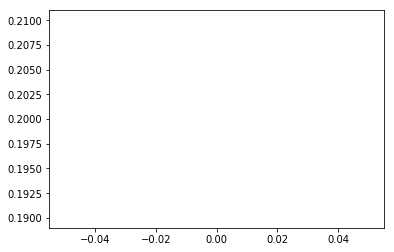

| Reward: 76 | Episode: 1 


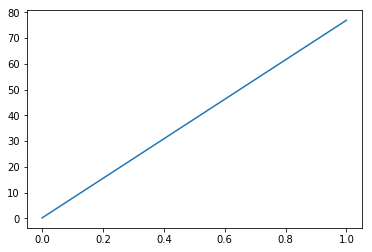

| Reward: 80 | Episode: 2 


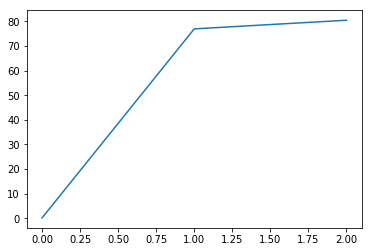

| Reward: 98 | Episode: 3 


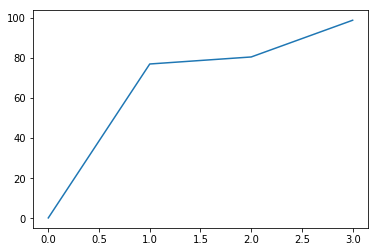

| Reward: 69 | Episode: 4 


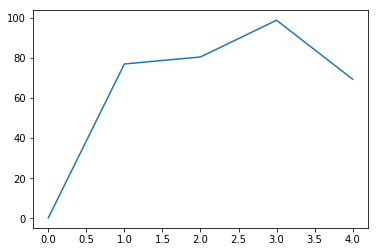

| Reward: 29 | Episode: 5 


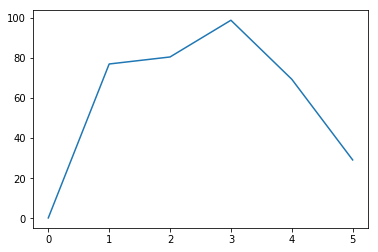

| Reward: 40 | Episode: 6 


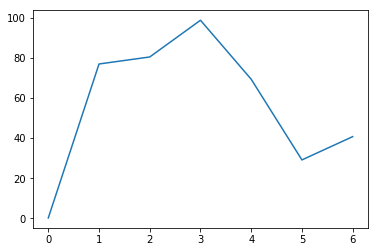

| Reward: 83 | Episode: 7 


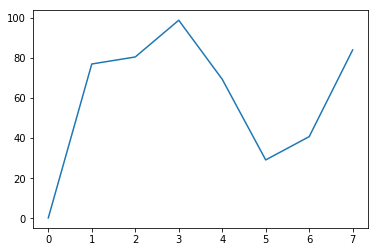

| Reward: 91 | Episode: 8 


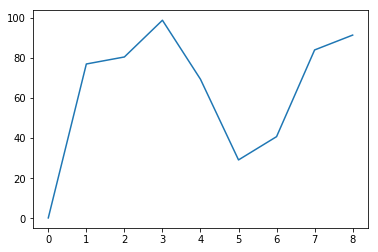

| Reward: 88 | Episode: 9 


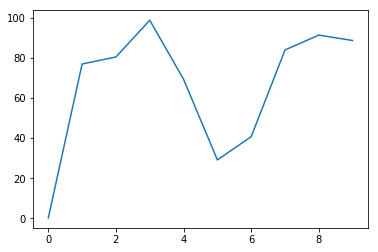

| Reward: 99 | Episode: 10 


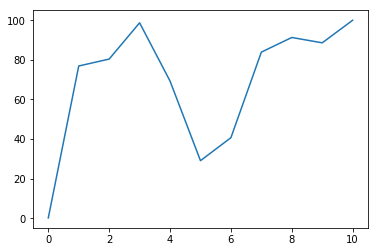

| Reward: 97 | Episode: 11 


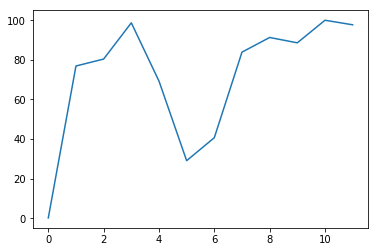

| Reward: 64 | Episode: 12 


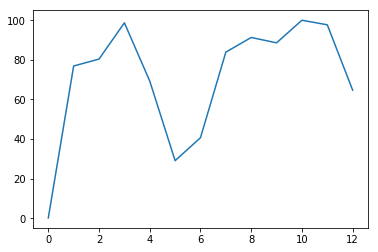

| Reward: 84 | Episode: 13 


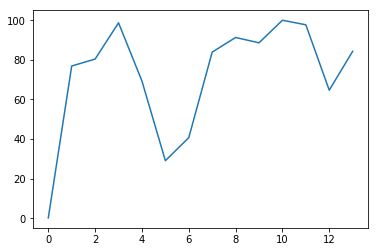

| Reward: 58 | Episode: 14 


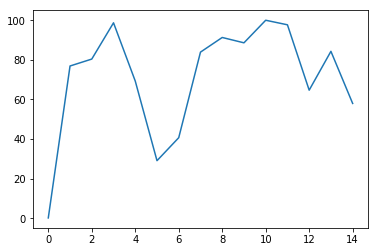

| Reward: 69 | Episode: 15 


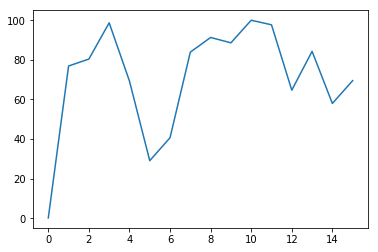

| Reward: 93 | Episode: 16 


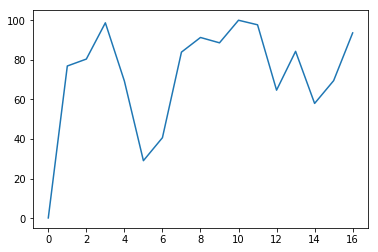

| Reward: 76 | Episode: 17 


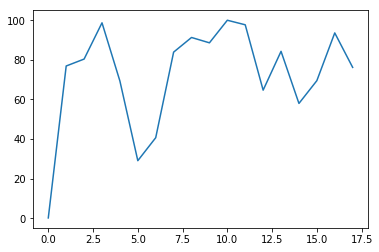

| Reward: 69 | Episode: 18 


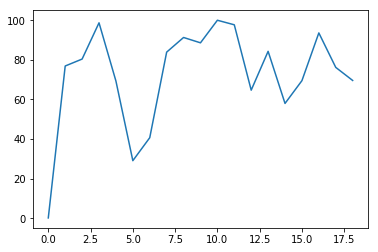

| Reward: 90 | Episode: 19 


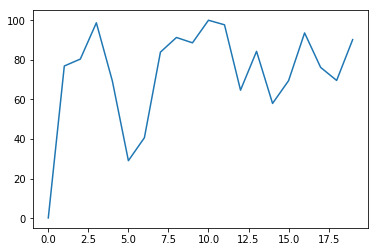

| Reward: 74 | Episode: 20 


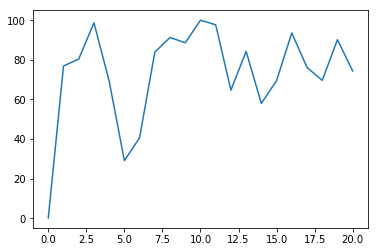

| Reward: 63 | Episode: 21 


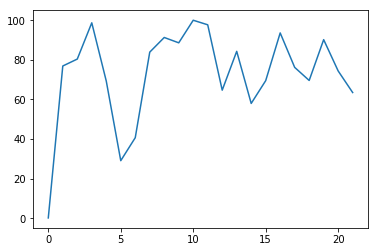

| Reward: 83 | Episode: 22 


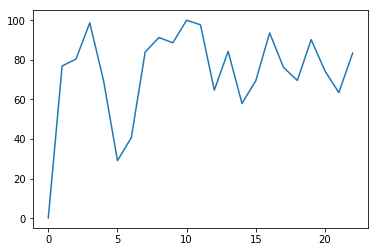

| Reward: 86 | Episode: 23 


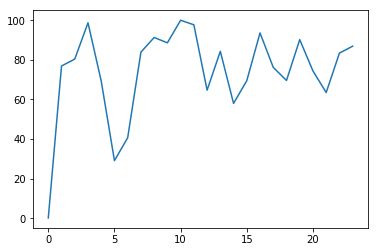

| Reward: 64 | Episode: 24 


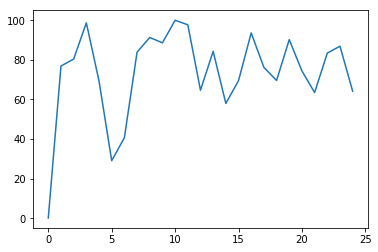

| Reward: 67 | Episode: 25 


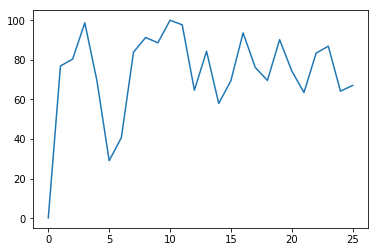

| Reward: 12 | Episode: 26 


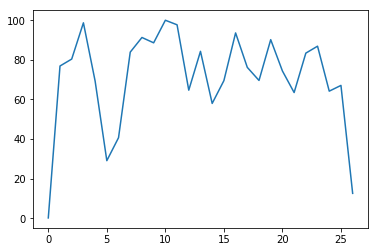

| Reward: 39 | Episode: 27 


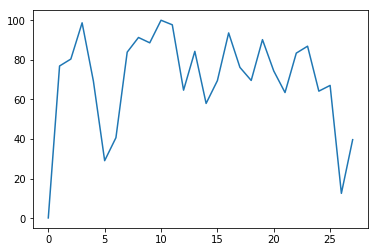

| Reward: 91 | Episode: 28 


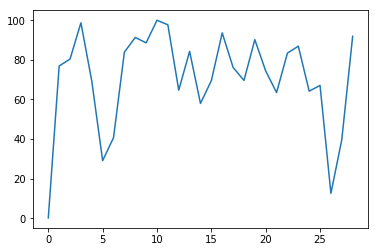

| Reward: 97 | Episode: 29 


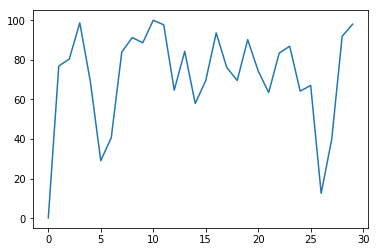

| Reward: 83 | Episode: 30 


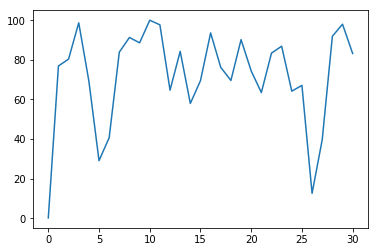

| Reward: 60 | Episode: 31 


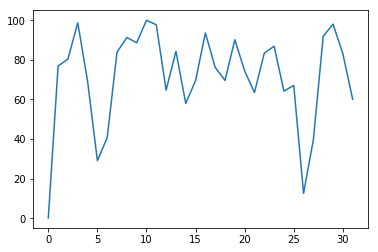

| Reward: 93 | Episode: 32 


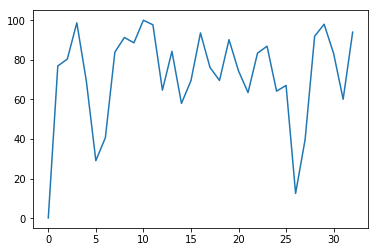

| Reward: 99 | Episode: 33 


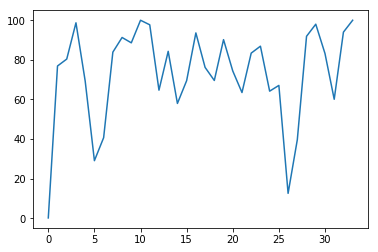

| Reward: 96 | Episode: 34 


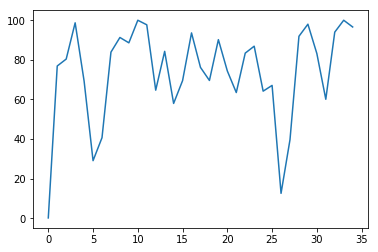

| Reward: 98 | Episode: 35 


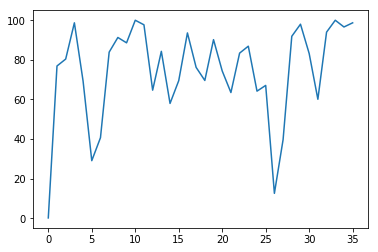

| Reward: 94 | Episode: 36 


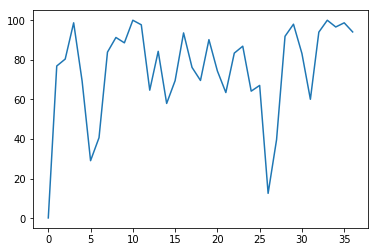

| Reward: 90 | Episode: 37 


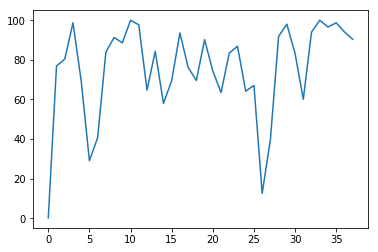

| Reward: 84 | Episode: 38 


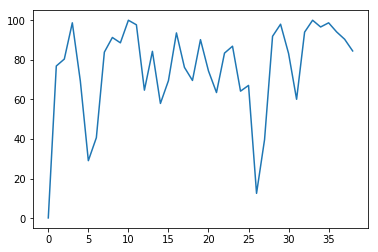

| Reward: 89 | Episode: 39 


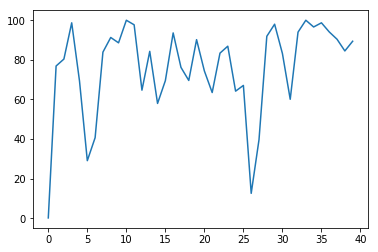

| Reward: 93 | Episode: 40 


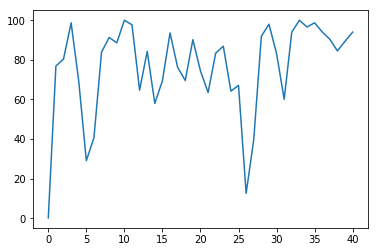

| Reward: 73 | Episode: 41 


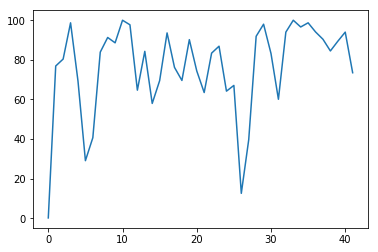

| Reward: 88 | Episode: 42 


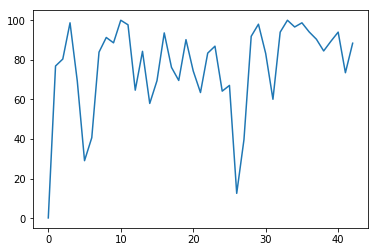

| Reward: 99 | Episode: 43 


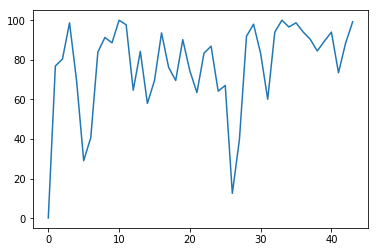

| Reward: 92 | Episode: 44 


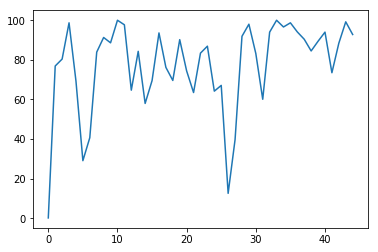

| Reward: 94 | Episode: 45 


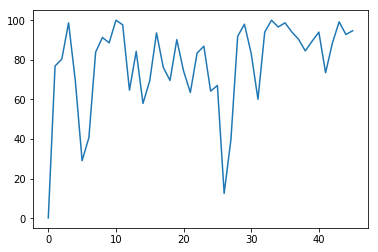

| Reward: 94 | Episode: 46 


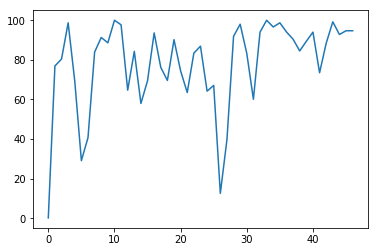

| Reward: 99 | Episode: 47 


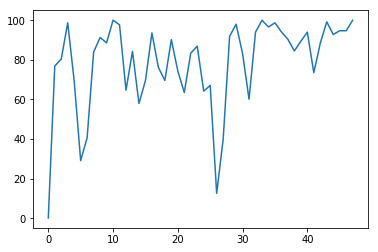

| Reward: 99 | Episode: 48 


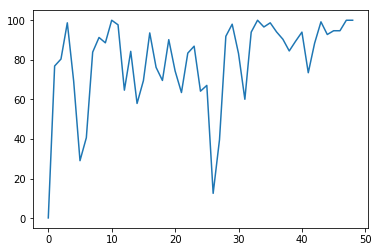

| Reward: 97 | Episode: 49 


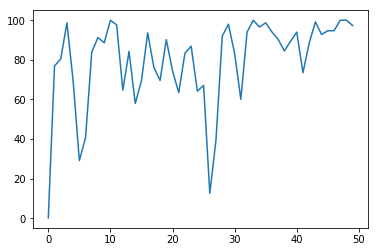

| Reward: 91 | Episode: 50 


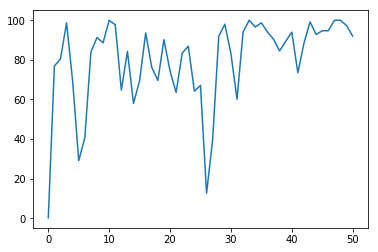

| Reward: 99 | Episode: 51 


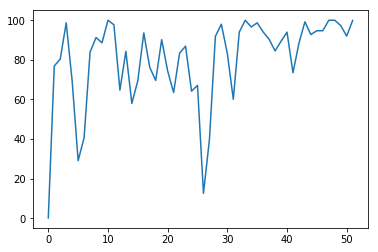

| Reward: 98 | Episode: 52 


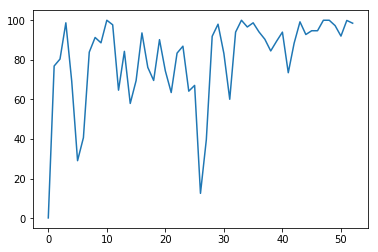

| Reward: 99 | Episode: 53 


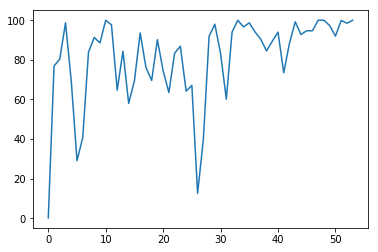

| Reward: 89 | Episode: 54 


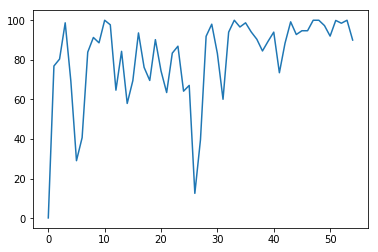

| Reward: 95 | Episode: 55 


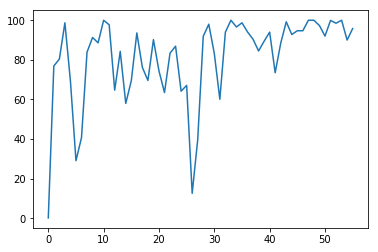

| Reward: 99 | Episode: 56 


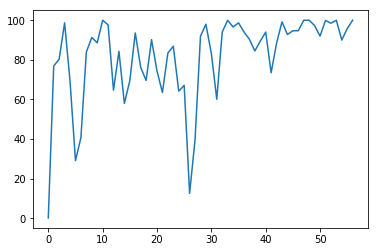

| Reward: 80 | Episode: 57 


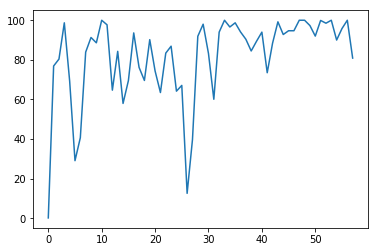

| Reward: 96 | Episode: 58 


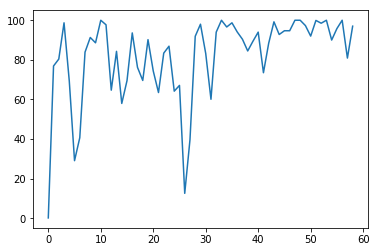

| Reward: 62 | Episode: 59 


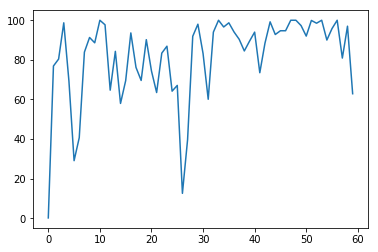

| Reward: 77 | Episode: 60 


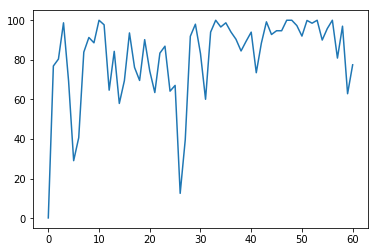

| Reward: 98 | Episode: 61 


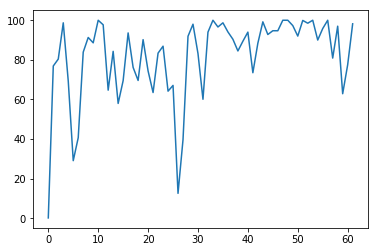

| Reward: 49 | Episode: 62 


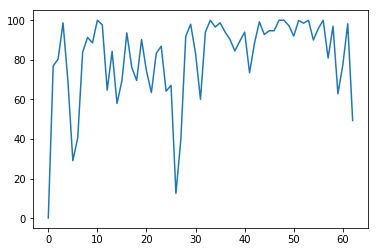

| Reward: 99 | Episode: 63 


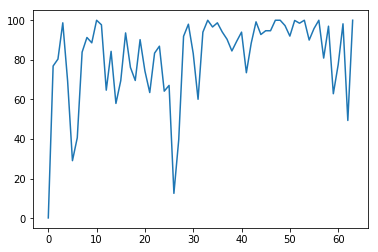

| Reward: 96 | Episode: 64 


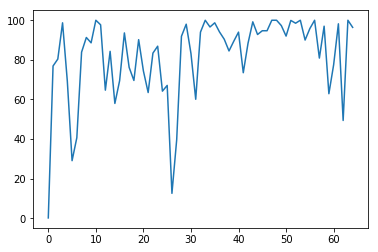

| Reward: 99 | Episode: 65 


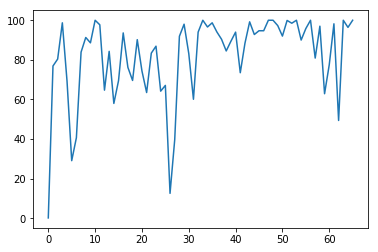

| Reward: 57 | Episode: 66 


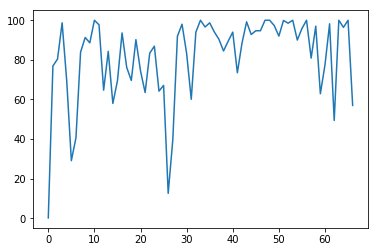

| Reward: 67 | Episode: 67 


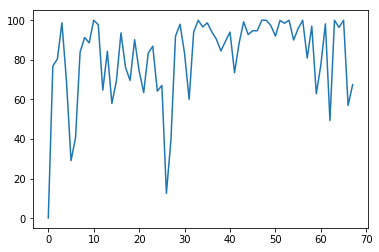

| Reward: 99 | Episode: 68 


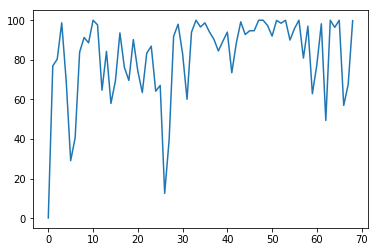

| Reward: 78 | Episode: 69 


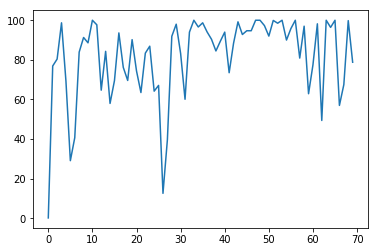

| Reward: 99 | Episode: 70 


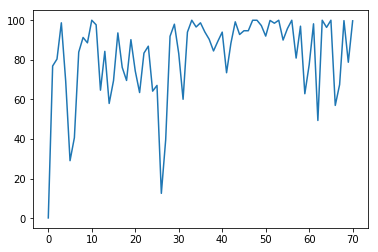

| Reward: 99 | Episode: 71 


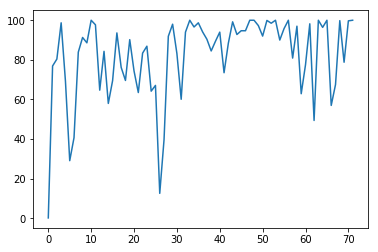

| Reward: 99 | Episode: 72 


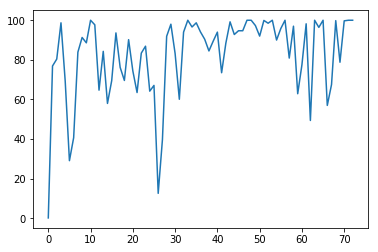

| Reward: 99 | Episode: 73 


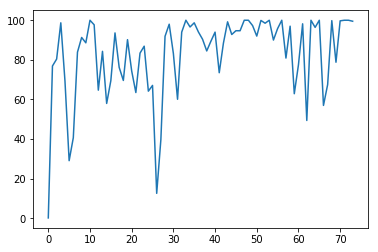

| Reward: 86 | Episode: 74 


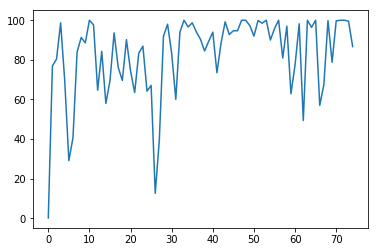

| Reward: 99 | Episode: 75 


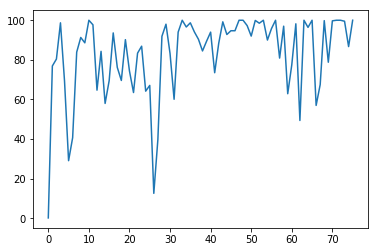

| Reward: 80 | Episode: 76 


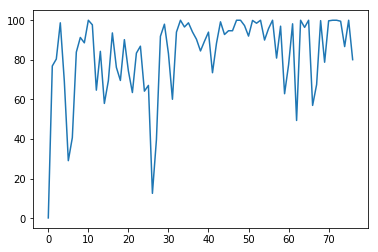

| Reward: 99 | Episode: 77 


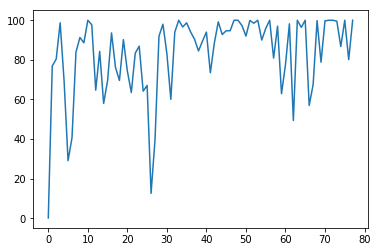

| Reward: 99 | Episode: 78 


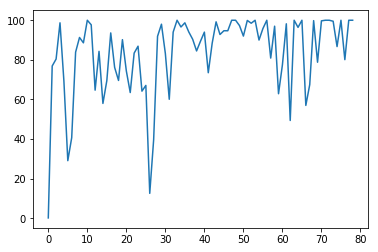

| Reward: 99 | Episode: 79 


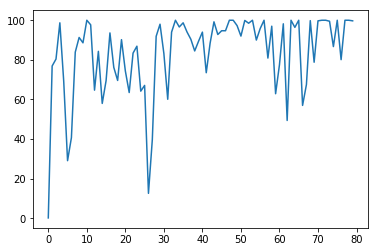

| Reward: 99 | Episode: 80 


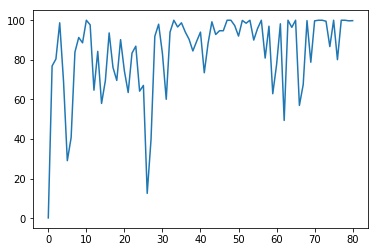

| Reward: 99 | Episode: 81 


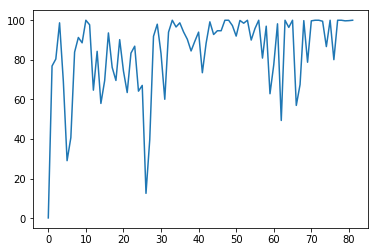

| Reward: 53 | Episode: 82 


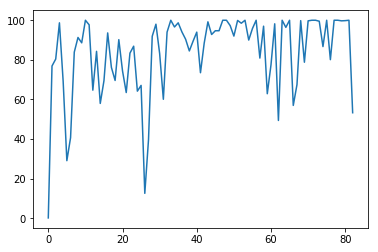

| Reward: 72 | Episode: 83 


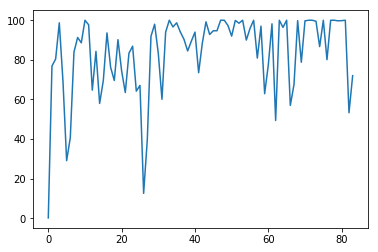

| Reward: 99 | Episode: 84 


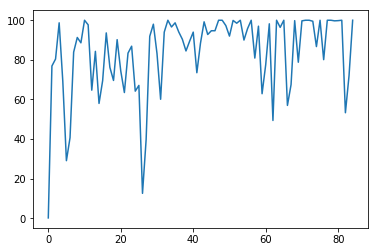

| Reward: 99 | Episode: 85 


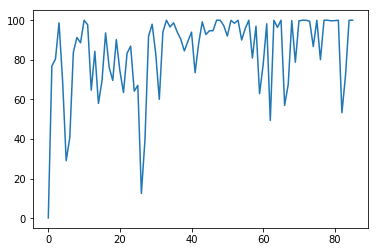

| Reward: 92 | Episode: 86 


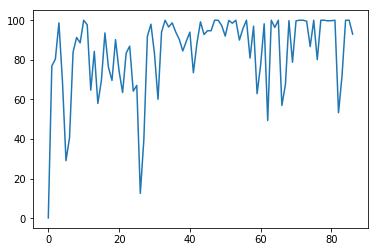

| Reward: 88 | Episode: 87 


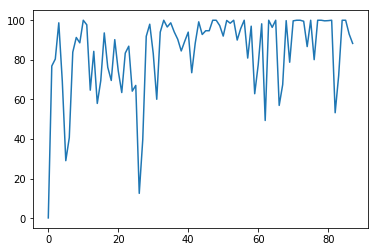

| Reward: 94 | Episode: 88 


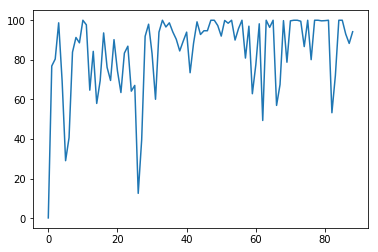

| Reward: 98 | Episode: 89 


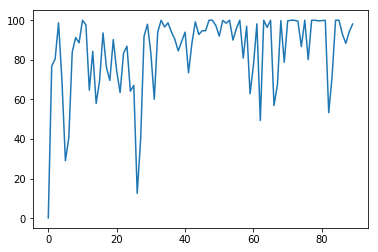

| Reward: 95 | Episode: 90 


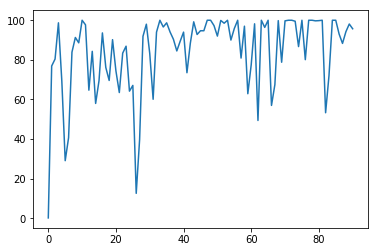

| Reward: 99 | Episode: 91 


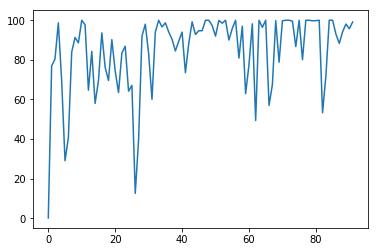

| Reward: 96 | Episode: 92 


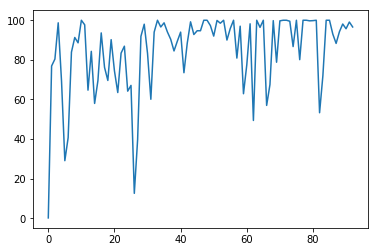

| Reward: 90 | Episode: 93 


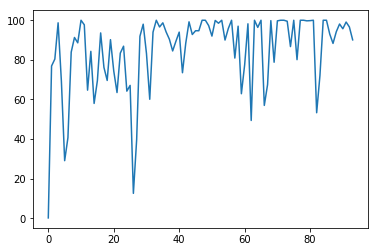

| Reward: 99 | Episode: 94 


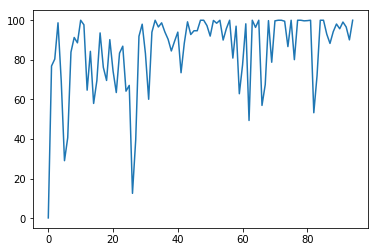

| Reward: 97 | Episode: 95 


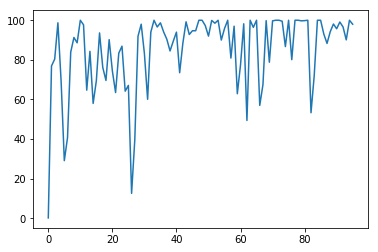

| Reward: 98 | Episode: 96 


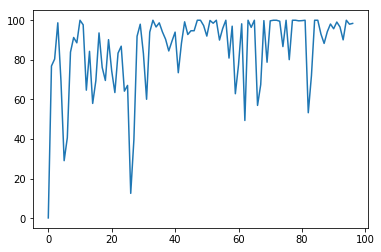

| Reward: 99 | Episode: 97 


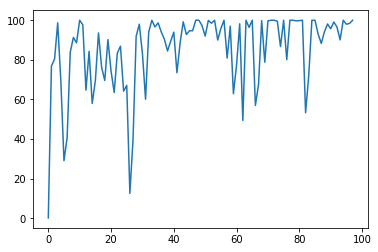

| Reward: 98 | Episode: 98 


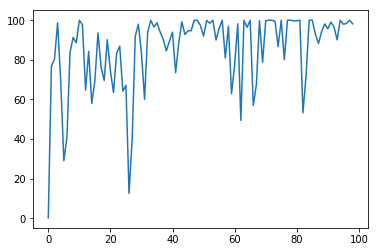

| Reward: 99 | Episode: 99 


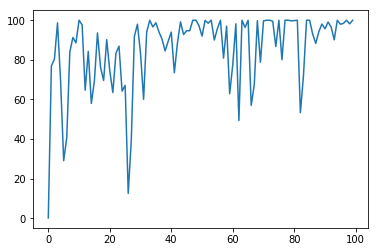

| Reward: 99 | Episode: 100 


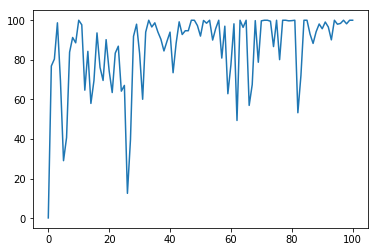

| Reward: 98 | Episode: 101 


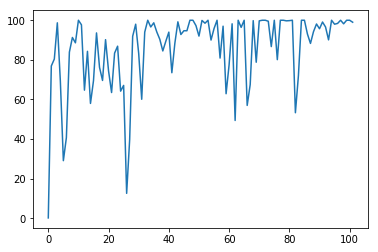

| Reward: 99 | Episode: 102 


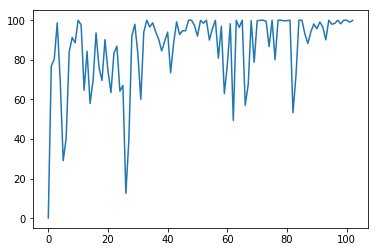

| Reward: 95 | Episode: 103 


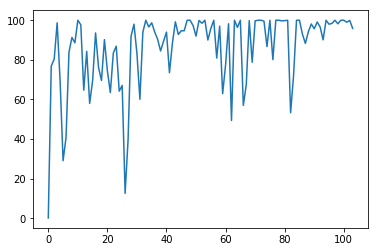

| Reward: 99 | Episode: 104 


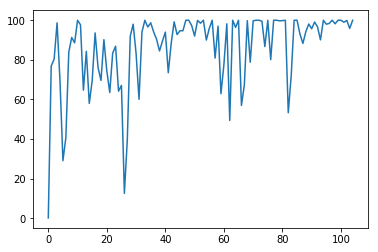

| Reward: 99 | Episode: 105 


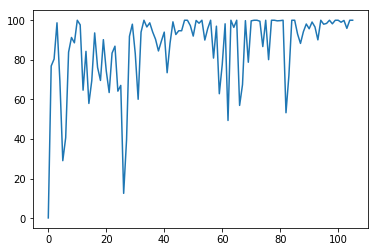

| Reward: 98 | Episode: 106 


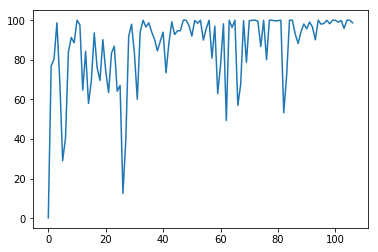

| Reward: 68 | Episode: 107 


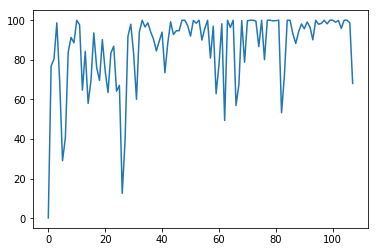

| Reward: 77 | Episode: 108 


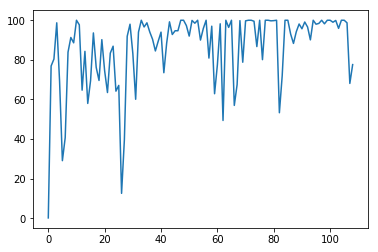

| Reward: 97 | Episode: 109 


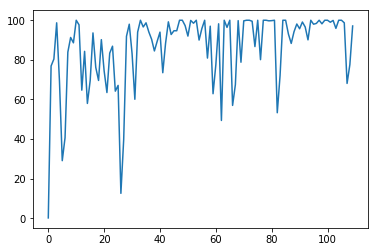

| Reward: 93 | Episode: 110 


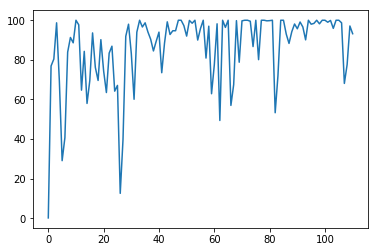

| Reward: 99 | Episode: 111 


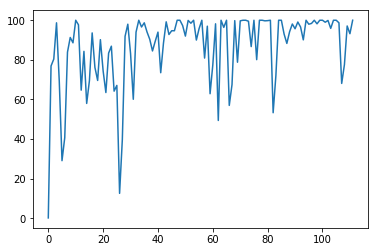

In [ ]:
with tf.Session() as sess:

    #env = gym.make('Pendulum-v0')
    #env = gym.make('MountainCarContinuous-v0')
    env = LASEnv('127.0.0.1', 19997)

    LASAgent = LASAgent_Actor_Critic(sess, env,
                                     actor_lr = 0.001, critic_lr = 0.001,
                                     actor_tau = 0.001, critic_tau = 0.001)

    #LASAgent.train()

    # Learning records
    episod_reward_memory = deque(maxlen = 10000)

    # Train parameters
    max_episodes = 500
    max_episode_len = 1000
    render_env = False
    reward = 0
    done = False
    for i in range(max_episodes):
        observation = env.reset()   
        ep_reward = 0    
        for j in range(max_episode_len):

            if render_env == True:
                env.render()

            # Added exploration noise
            action = LASAgent.perceive_and_act(observation,reward,done)

            observation, reward, done, info = env.step(action[0])
            ep_reward += reward
            if done or j == (max_episode_len-1):
                print('| Reward: {:d} | Episode: {:d} '.format(int(ep_reward),i))
                episod_reward_memory.append(ep_reward)
                plot_cumulative_reward(episod_reward_memory)
                break

    env.destroy()

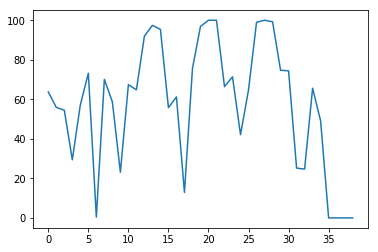

In [7]:
plot_cumulative_reward(LASAgent.episod_reward_memory)

In [ ]:
env.destroy()